# Introduction

When entering a query in a general search engine such as Google and Bing, a drop-down list of suggestions will typically appear. These suggestions modify the query in essentially two ways: 1. they correct possible typos, and 2. atempt to complete them. Both steps require some level of semantic understanding and language models are therefore called for. This notebook explores the use of pretrained transformer-based language models for this task. We will be using two datasets: 1. the [MSMARCO Queries dataset](https://microsoft.github.io/MSMARCO-Question-Answering/), a curated list of Bing user queries, and 2. the [Webis-QSpell-17](https://webis.de/data/webis-qspell-17.html) dataset, a corpus of web queries extracted from the [AOL Query Logs dataset](https://webis.de/data/webis-qspell-17.html), of which some contain possible mistakes and are presented along with spelling variants. For simplicity, autocompletion here does *not* include completing partial words (e.g. 'how to tie a t' -> 'how to tie a tie'), though the techniques used could easily be adapted to accomodate that more general setting.

# 0. Preliminaries

## 0.1 Libraries and packages
Before getting started, we load some relevant libraries and packages.

In [ ]:
!pip install transformers
!pip install sentence-transformers
!pip install sacrebleu
import nltk
nltk.download('punkt')

     |████████████████████████████████| 2.6 MB 8.2 MB/s 
     |████████████████████████████████| 3.3 MB 77.5 MB/s 
     |████████████████████████████████| 636 kB 80.9 MB/s 
     |████████████████████████████████| 895 kB 74.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 85 kB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 36.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=504ce08e2221ddc8139eb273b204d7121f974c72402e2e40fa2728728aaa03ff
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
     |████████████████████████████████| 90 kB 5.9 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!wget -nc https://msmarco.blob.core.windows.net/msmarcoranking/queries.tar.gz
!tar xzvf queries.tar.gz

File ‘queries.tar.gz’ already there; not retrieving.

queries.dev.tsv
queries.eval.tsv
queries.train.tsv


## 0.2 Fetching the MSMARCO Data

Let's download the MSMARCO Queries dataset. It consists of three suggestively-named  files: one for training, one for validation and one for testing.

In [ ]:
import pandas as pd

train_queries = pd.read_csv('queries.train.tsv', names=['id', 'query'], sep='\t')
dev_queries = pd.read_csv('queries.dev.tsv', names=['id', 'query'], sep='\t')
eval_queries = pd.read_csv('queries.eval.tsv', names=['id', 'query'], sep='\t')
train_queries = train_queries.dropna()
dev_queries = dev_queries.dropna()
eval_queries = eval_queries.dropna()

Let's see what the dataset looks like.

In [ ]:
train_queries.head(10)

,id,query
0,121352,define extreme
1,634306,what does chattel mean on credit history
2,920825,what was the great leap forward brainly
3,510633,tattoo fixers how much does it cost
4,737889,what is decentralization process.
5,278900,how many cars enter the la jolla concours d' e...
6,674172,what is a bank transit number
7,303205,how much can i contribute to nondeductible ira
8,570009,what are the four major groups of elements
9,492875,sanitizer temperature


Let's get basic statistical information about the lengths of the user queries.

In [ ]:
print('Train data has', len(train_queries), 'samples')
print('Validation data has', len(dev_queries), 'samples')
print('Test data has', len(eval_queries), 'samples')

Train data has 808731 samples
Validation data has 101093 samples
Test data has 101092 samples


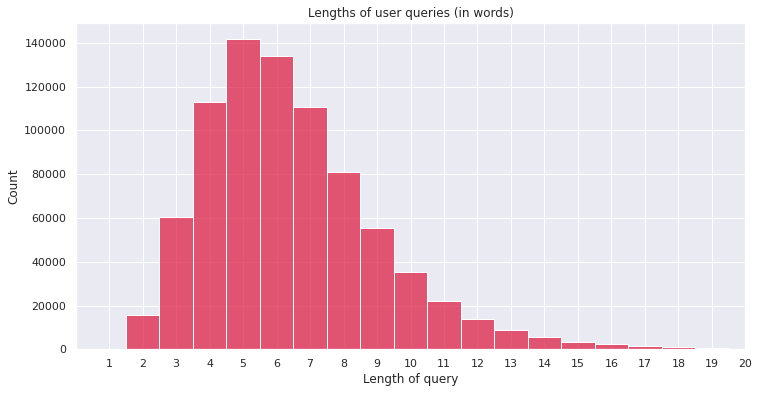

Mean query length: 6.485220672881341 words
Std. dev. of query length: 2.7594759665447004 words
Longest query: 81 words
Shortest query: 1 words


In [ ]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np

sns.set(style='darkgrid', palette=sns.diverging_palette(145, 400, s=20, l=30,
                                                        n=8))
fig, ax = plt.subplots(figsize=(12, 6))
sep_queries = [word_tokenize(query) for query in train_queries['query'].tolist()]
query_lens = [len(query) for query in sep_queries]
plt.title('Lengths of user queries (in words)')
plt.xlabel('Length of query')
plt.xlim(0, 20)
plt.xticks(range(1, 21))
sns.histplot(data=query_lens, ax=ax, color='crimson', alpha=0.7, 
             bins=np.arange(21)-0.5)
plt.show()
print('Mean query length:', np.mean(query_lens), 'words')
print('Std. dev. of query length:', np.std(query_lens), 'words')
print('Longest query:', max(query_lens), 'words')
print('Shortest query:', min(query_lens), 'words')

# 1. Implementation

We want to build a system that, given a partial query (with possible typos) as an input, will output a ranked list of suggestions that correct and extend the partial query. There are two stages: autocorrection and autocompletion. We will build two prototypes. One will be modular, handling the two stages seperately, and one will be end-to-end, handling the two at once.

In the modular system, we will use [BERT](https://arxiv.org/abs/1810.04805) along with [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) for autocorrection and autocompletion respectively. This choice is informed by the two models' respective training regimens. Indeed, BERT employs masked language modeling, a denoising task, whereas GPT-2 employs causal language modeling, a predictive task, making each well-suited for the role delegated to it.

The end-to-end sstem will be based on [BART](https://arxiv.org/abs/1910.13461), which is a full encoder-decoder transformer model designed for both masked and causal language modeling.

We will use the Huggingface API to invoke the three language models.

## 1.1 System 1: Modular model

### 1.1.1 Fine-tuning BERT
Let's load and fine-tune BERT-base on the queries in 'queries.train.tsv', using the queries in 'dev.train.tsv' for validation. Based on the mean query length observed above, the maximum encoded length will be set to 16 tokens. The training task is simply masked language modeling: each token effectively has a 13.5% probability of getting corrupted and the task is to recover the original token.

In [ ]:
from transformers import AutoTokenizer, AutoModel, BertForMaskedLM
 
bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', 
                                          model_max_length=16)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_queries_texts = train_queries['query'].tolist()
dev_queries_texts = dev_queries['query'].tolist()
en_train_queries_texts = [bert_tokenizer(query, truncation=True) for query in train_queries_texts]
en_dev_queries_texts = [bert_tokenizer(query, truncation=True) for query in dev_queries_texts]

In [ ]:
from transformers import (DataCollatorForLanguageModeling, Trainer, 
                         TrainingArguments)
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
bert_dir = './local_trained_bert/'

bert_collator = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, 
                                                mlm=True,
                                                pad_to_multiple_of=16)
bert_training_args = TrainingArguments(
    learning_rate=5e-5,
    output_dir=bert_dir,
    overwrite_output_dir=True,
    num_train_epochs=5,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=512,
    per_device_eval_batch_size=1024,
    prediction_loss_only=True)

bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    data_collator=bert_collator,
    train_dataset=en_train_queries_texts,
    eval_dataset=en_dev_queries_texts)

In [ ]:
#bert_trainer.train()
#bert_trainer.save_model()

In [ ]:
## uncomment below to reload model
# bert_model = BertForMaskedLM.from_pretrained(bert_dir)

In [ ]:
# put model back on cpu and on eval mode for inference
bert_model.to('cpu');
bert_model.eval();

### 1.1.2 Fine-tuning GPT-2
We now load GPT-2 and fine-tune it. Recall that whereas we used BERT to implement autocorrection, we intend to use GPT-2 for autocompletion. The task is causal language modeling: given an input sequence predict the next token in it.

In [ ]:
from transformers import GPT2LMHeadModel

gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2", model_max_length=16)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=gpt_tokenizer.eos_token_id)

Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/gpt2/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwt1o0l0n


storing https://huggingface.co/gpt2/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
creating metadata file for /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "m

https://huggingface.co/gpt2/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpp_4vppm4


storing https://huggingface.co/gpt2/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
creating metadata file for /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f


https://huggingface.co/gpt2/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp6et5pdk4


storing https://huggingface.co/gpt2/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b


https://huggingface.co/gpt2/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpzj3imnc1


storing https://huggingface.co/gpt2/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/16a2f78023c8dc511294f0c97b5e10fde3ef9889ad6d11ffaa2a00714e73926e.cf2d0ecb83b6df91b3dbb53f1d1e4c311578bfd3aa0e04934215a49bf9898df0
creating metadata file for /root/.cache/huggingface/transformers/16a2f78023c8dc511294f0c97b5e10fde3ef9889ad6d11ffaa2a00714e73926e.cf2d0ecb83b6df91b3dbb53f1d1e4c311578bfd3aa0e04934215a49bf9898df0


loading file https://huggingface.co/gpt2/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
loading file https://huggingface.co/gpt2/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/gpt2/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/16a2f78023c8dc511294f0c97b5e10fde3ef9889ad6d11ffaa2a00714e73926e.cf2d0ecb83b6df91b3dbb53f1d1e4c311578bfd3aa0e04934215a49bf9898df0
loading file https://huggingface.co/gpt2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/gpt2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/gpt2/resolve/main/tokenizer_con

storing https://huggingface.co/gpt2/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e.323c769945a351daa25546176f8208b3004b6f563438a7603e7932bae9025925
creating metadata file for /root/.cache/huggingface/transformers/752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e.323c769945a351daa25546176f8208b3004b6f563438a7603e7932bae9025925
loading weights file https://huggingface.co/gpt2/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e.323c769945a351daa25546176f8208b3004b6f563438a7603e7932bae9025925


All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


In [ ]:
en_train_queries_texts = [gpt_tokenizer(query, truncation=True) for query in train_queries_texts]
en_dev_queries_texts = [gpt_tokenizer(query, truncation=True) for query in dev_queries_texts]

In [ ]:
gpt_model.to(device)
gpt_dir = './local_trained_gpt/'

gpt_collator = DataCollatorForLanguageModeling(tokenizer=gpt_tokenizer, 
                                                mlm=False,
                                                pad_to_multiple_of=16)
gpt_training_args = TrainingArguments(
    learning_rate=2e-5,
    output_dir=gpt_dir,
    overwrite_output_dir=True,
    num_train_epochs=5,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=128,
    per_device_eval_batch_size=512,
    gradient_accumulation_steps=2,
    prediction_loss_only=True)

gpt_trainer = Trainer(
    model=gpt_model,
    args=gpt_training_args,
    data_collator=gpt_collator,
    train_dataset=en_train_queries_texts,
    eval_dataset=en_dev_queries_texts)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
gpt_trainer.train()
gpt_trainer.save_model()

***** Running training *****
  Num examples = 808731
  Num Epochs = 5
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 2
  Total optimization steps = 15795


Epoch,Training Loss,Validation Loss
0,4.490900,4.378908
1,4.329300,4.289423
2,4.255000,4.248666
3,4.203900,4.229917
4,4.174900,4.224312


***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_gpt/checkpoint-3159
Configuration saved in ./local_trained_gpt/checkpoint-3159/config.json
Model weights saved in ./local_trained_gpt/checkpoint-3159/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_gpt/checkpoint-6318
Configuration saved in ./local_trained_gpt/checkpoint-6318/config.json
Model weights saved in ./local_trained_gpt/checkpoint-6318/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_gpt/checkpoint-9477
Configuration saved in ./local_trained_gpt/checkpoint-9477/config.json
Model weights saved in ./local_trained_gpt/checkpoint-9477/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_gpt/checkpoint-12636
Configu

In [ ]:
## uncomment below to reload model
# gpt_model = GPT2LMHeadModel.from_pretrained(gpt_dir, pad_token_id=gpt_tokenizer.eos_token_id)

In [ ]:
# put model back on cpu and on eval mode for inference
gpt_model.to('cpu');
gpt_model.eval();

## 1.2 System 2: End-to-end model

With the modular system now in place, we build an end-to-end system leveraing BART. The training task will consist of both masked and causal language modeling. Due to BART having an encoder, we have to manually modify the inputs so that look-ahead leakage does not occur in the causal language modeling task. This stands to make the model even more end-to-end: we would like the system to extend queries by a few words, and by manually modifying the inputs we can train the system to extend queries at once rather than one word at a time. 

In [ ]:
from transformers import BartForConditionalGeneration

bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
bart_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base', 
                                          model_max_length=16)

https://huggingface.co/facebook/bart-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpu8j7zk7o


storing https://huggingface.co/facebook/bart-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.8512cdf8592f538a7fd4b40eecaa096285410ec6494049568b3300922ab71165
creating metadata file for /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.8512cdf8592f538a7fd4b40eecaa096285410ec6494049568b3300922ab71165
loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.8512cdf8592f538a7fd4b40eecaa096285410ec6494049568b3300922ab71165
Model config BartConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "class

https://huggingface.co/facebook/bart-base/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpdyl8azen


storing https://huggingface.co/facebook/bart-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/486355ec722ef05fd480e999d4c763be56549ae930f6a3742ee721a5d2a05647.9faea28a6782a9589c09b1942c039943df02232d83d2ac288a69ddfa928eae22
creating metadata file for /root/.cache/huggingface/transformers/486355ec722ef05fd480e999d4c763be56549ae930f6a3742ee721a5d2a05647.9faea28a6782a9589c09b1942c039943df02232d83d2ac288a69ddfa928eae22
loading weights file https://huggingface.co/facebook/bart-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/486355ec722ef05fd480e999d4c763be56549ae930f6a3742ee721a5d2a05647.9faea28a6782a9589c09b1942c039943df02232d83d2ac288a69ddfa928eae22


All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BartForConditionalGeneration for predictions without further training.
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.8512cdf8592f538a7fd4b40eecaa096285410ec6494049568b3300922ab71165
Model config BartConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout

storing https://huggingface.co/facebook/bart-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/43978bdeaa326572886b44fcfed82f932f76571095ce31973e51c3da8ccade7f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/43978bdeaa326572886b44fcfed82f932f76571095ce31973e51c3da8ccade7f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab


https://huggingface.co/facebook/bart-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp7tzzjn8j


storing https://huggingface.co/facebook/bart-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/3c167ed8af56e6605eeb794b63a79d65d85e6708c9b04408d41946337030f5cd.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/3c167ed8af56e6605eeb794b63a79d65d85e6708c9b04408d41946337030f5cd.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b


https://huggingface.co/facebook/bart-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9qpuq2bb


storing https://huggingface.co/facebook/bart-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/a878fcd69bba037c9b1b227f4213579ae43d0aaa9374e167bc6c5f41b1cfeb30.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/a878fcd69bba037c9b1b227f4213579ae43d0aaa9374e167bc6c5f41b1cfeb30.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730


loading file https://huggingface.co/facebook/bart-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/43978bdeaa326572886b44fcfed82f932f76571095ce31973e51c3da8ccade7f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/facebook/bart-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/3c167ed8af56e6605eeb794b63a79d65d85e6708c9b04408d41946337030f5cd.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/facebook/bart-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/a878fcd69bba037c9b1b227f4213579ae43d0aaa9374e167bc6c5f41b1cfeb30.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/facebook/bart-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/facebook/bart-base/resolve/main/special_tokens_map.json from cache at No

In [ ]:
from transformers import AutoConfig
from numpy.random import choice

class bart_collator_class():
  """Data collator for BART."""
  def __init__(self, tokenizer=bart_tokenizer, mlm=True, mlm_probability=0.15, 
               pad_to_multiple_of=16):
    self.tokenizer = tokenizer
    self.mask_bart_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, 
                                                     mlm=mlm, 
                                                     mlm_probability=mlm_probability, 
                
                                                     pad_to_multiple_of=pad_to_multiple_of)
    config = AutoConfig.from_pretrained('facebook/bart-base')
    self.end_token = config.eos_token_id
    self.pad_to_multiple_of=pad_to_multiple_of

  def __call__(self, features_ls):
    # extract ids and attention masks
    input_ids_ls = [features['input_ids'] for features in features_ls]
    attn_mask_ls = [features['attention_mask'] for features in features_ls]
    labels_ls = [features.get('labels', features['input_ids']) for features in features_ls]

    # randomly truncate
    to_truncate_ls = choice(3, size=len(features_ls), p=[1/3, 1/3, 1/3])
    new_input_ids_ls = []
    new_attn_mask_ls = []
    new_labels_ls = []

    for i, input_ids in enumerate(input_ids_ls):
      labels = labels_ls[i]
      labels = np.pad(labels, (0, 16-len(labels)), constant_values=(0, -100))
      attn_mask = attn_mask_ls[i]
      to_truncate = int(to_truncate_ls[i])
      if to_truncate:
        input_ids = input_ids[:-to_truncate]
        input_ids[-1] = self.end_token
        attn_mask = attn_mask[:-to_truncate]
      new_input_ids_ls.append(input_ids)
      new_attn_mask_ls.append(attn_mask)
      new_labels_ls.append(labels)

    new_labels_ls = [torch.tensor(labels, dtype=torch.long) for labels in new_labels_ls]
    labels_tensor = torch.stack(new_labels_ls)

    dic_ls = [{'input_ids': new_input_ids_ls[i], 
               'attention_mask': new_attn_mask_ls[i]} for i in range(len(new_input_ids_ls))]
    batch = self.mask_bart_collator(dic_ls)
    batch['labels'] = labels_tensor

    return batch

# unit tests
bart_collator = bart_collator_class()
batch = bart_collator(en_train_queries_texts[:10])
assert(batch['input_ids'].shape == batch['labels'].shape)
assert(batch['input_ids'].shape == batch['attention_mask'].shape)

loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.8512cdf8592f538a7fd4b40eecaa096285410ec6494049568b3300922ab71165
Model config BartConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABE

In [ ]:
en_train_queries_texts = [bart_tokenizer(query, truncation=True) for query in train_queries_texts]
en_dev_queries_texts = [bart_tokenizer(query, truncation=True) for query in dev_queries_texts]

In [ ]:
bart_model.to(device)
bart_dir = './local_trained_bart/'

bart_collator = bart_collator_class(mlm_probability=0.33)

bart_training_args = TrainingArguments(
    learning_rate=3e-5,
    output_dir=bart_dir,
    overwrite_output_dir=True,
    num_train_epochs=5,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=256,
    per_device_eval_batch_size=512,
    prediction_loss_only=True)

bart_trainer = Trainer(
    model=bart_model,
    args=bart_training_args,
    data_collator=bart_collator,
    train_dataset=en_train_queries_texts,
    eval_dataset=en_dev_queries_texts
)

loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.8512cdf8592f538a7fd4b40eecaa096285410ec6494049568b3300922ab71165
Model config BartConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABE

In [ ]:
bart_trainer.train()
bart_trainer.save_model()

***** Running training *****
  Num examples = 808731
  Num Epochs = 5
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 15800


Epoch,Training Loss,Validation Loss
1,1.249200,1.164498
2,1.180300,1.123674
3,1.140500,1.101693
4,1.114100,1.089637


***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_bart/checkpoint-3160
Configuration saved in ./local_trained_bart/checkpoint-3160/config.json
Model weights saved in ./local_trained_bart/checkpoint-3160/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_bart/checkpoint-6320
Configuration saved in ./local_trained_bart/checkpoint-6320/config.json
Model weights saved in ./local_trained_bart/checkpoint-6320/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_bart/checkpoint-9480
Configuration saved in ./local_trained_bart/checkpoint-9480/config.json
Model weights saved in ./local_trained_bart/checkpoint-9480/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_bart/checkpoint-126

Epoch,Training Loss,Validation Loss
1,1.249200,1.164498
2,1.180300,1.123674
3,1.140500,1.101693
4,1.114100,1.089637
5,1.104400,1.084677


***** Running Evaluation *****
  Num examples = 101093
  Batch size = 512
Saving model checkpoint to ./local_trained_bart/checkpoint-15800
Configuration saved in ./local_trained_bart/checkpoint-15800/config.json
Model weights saved in ./local_trained_bart/checkpoint-15800/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./local_trained_bart/checkpoint-15800 (score: 1.0846766233444214).
Saving model checkpoint to ./local_trained_bart/
Configuration saved in ./local_trained_bart/config.json
Model weights saved in ./local_trained_bart/pytorch_model.bin


In [ ]:
## uncomment below to reload model
# bart_model = BartForConditionalGeneration.from_pretrained(bart_dir)

In [ ]:
# put model back on cpu and on eval mode for inference
bart_model.to('cpu');
bart_model.eval();

## 1.3 Implementing autocorrection and autocompletion

With the two systems now trained, we implement facilities for autocorrection and autocompletion. For System 1, autocorrection will proceed by replacing possible typos with in-vocabulary words within an [edit distance](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance) of 2 using the probabilities provided by BERT and autocompletion is performed by GPT-2. System 2 on the other hand mimics its training task: it first masks out-of-vocabulary words and then attempts to both denoise and extend the query. Since the language models we are using have the ability to simply output their inputs (e.g. the models can output 'Diana's ring' having seen 'Diana's rig' even though Diana is not part of their vocabularies), we wish try be conservative at the autorrection stage and consequently extend the models' vocabularies by [a large list of English words](https://github.com/dwyl/english-words).

### Autocorrection

We use [Peter Norvig](http://norvig.com/spell-correct.html)'s code to obtain the words within an edit distance of 2 of a given input word.

In [ ]:
# credit to Peter Norvig
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return deletes + transposes + replaces + inserts

def edits2(word): 
    "All edits that are two edits away from `word`."
    return set([e2 for e1 in edits1(word) for e2 in edits1(e1)])

In [ ]:
!wget -nc https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt
ref_vocab = set([])
with open('words_alpha.txt', 'r') as file:
  for line in file:
    ref_vocab.add(line.strip())

File ‘words_alpha.txt’ already there; not retrieving.



In [ ]:
from scipy.special import softmax
from transformers import set_seed

# class implementing autocorrection
class autocorrect():
  def __init__(self, corr_model, corr_tok, mode='correct'):
    self.corr_model = corr_model
    self.corr_tok = corr_tok
    self.mode = mode
    self.ref_vocab = set(corr_tok.get_vocab()).union(ref_vocab)
  
  def get_probs(self, sent, candidates, posn):
    """Expects a sentence 'sent' and word position 'posn',
    returns probabilities of being correct word at 'posn' for each word in 'candidates' using
    using masked language model 'corr_model' (with tokenizer 'corr_tok')
    """
    mask = self.corr_tok.decode(self.corr_tok.mask_token_id)
    sent[posn] = mask
    sent = ' '.join(sent)
    candidate_indices = [self.corr_tok.convert_tokens_to_ids(token) for token in candidates]
    en_sent = self.corr_tok(sent, return_tensors='pt')['input_ids']
    logits = self.corr_model(en_sent)['logits'].detach().cpu().numpy()[0,1+posn, candidate_indices]
    probs = softmax(logits)
    return list(probs)

  def __call__(self, query, beam_size=3):
    """Expects a query with some words possibly misspelled. 
    Returns suggested corrections to the query, using language model 
    'corr_model'. Performs beam search if mode='correct'.
    """
    query = word_tokenize(query)[:14] # limit to max length

    if self.mode == 'correct':
      top_beam = [(0, query)]

      for l in range(len(query)):
        all_beams = []
        candidates = edits2(query[l]).intersection(self.ref_vocab)
        if len(candidates) == 0:
          continue
        for prob, predict in top_beam:
          next_probs = self.get_probs(predict, candidates, l)
          candidates_probs = zip(candidates, next_probs)
          candidates_probs = sorted(candidates_probs, key=lambda t: t[1], 
                                    reverse=True)
          for candidate, next_prob in candidates_probs:
            all_beams.append(((prob*l - np.log(next_prob))/(l+1), predict[:l] + [candidate] + predict[l+1:]))
        top_beam = sorted(all_beams, key=lambda tup:tup[0])[:beam_size]
      corrections = [tup[1] for tup in top_beam]

    elif self.mode == 'mask':
      mask = self.corr_tok.decode(self.corr_tok.mask_token_id)
      for i, word in enumerate(query):
        if word not in self.ref_vocab: query[i] = mask
      corrections = [query]

    else:
      corrections = [query]
    
    corrections = [' '.join(correction) for correction in corrections]
    return corrections

# demo
system1_autocorrect = autocorrect(bert_model, bert_tokenizer, mode='correct')
system2_autocorrect = autocorrect(bart_model, bart_tokenizer, mode='mask')

# function get_probs
sentence = word_tokenize('my cat is very [MASK] today')
candidates = ['cute', 'hungry', 'angry']
probs = system1_autocorrect.get_probs(sentence, candidates, 4)
print(dict(zip(candidates, probs)))

# autocorrect
set_seed(1)
print(system1_autocorrect('machine learnni resourcs', beam_size=5))
print(system2_autocorrect('machine learnni resourcs'))

{'cute': 0.018123288, 'hungry': 0.95087606, 'angry': 0.031001028}
['marine learning resources', 'machine learning resources', 'vaccine learning resources', 'maine learning resources', 'machines learning resources']
['machine <mask> <mask>']


### Autocompletion

We are finally ready to bring everything together to define a function for the autocompletion of queries.

I noticed GPT-2 had a bias towards generating long texts, even when setting low values for the exponentiual length penalty. I therefore decided to specify the number of words to generate.

In [ ]:
# class implementing autocompletion, inherits from class 'autocorrect'
class autocomplete(autocorrect):
  def __init__(self, gen_model, gen_tok, **args):
    super().__init__(**args)
    self.gen_model = gen_model
    self.gen_tok = gen_tok

  def __call__(self, query, beam_size=3, to_add=16):
    """ Expects query 'query'. Calls function 'autocorrect' first to get suggested 
    corrections for the query if do_autocorrect=True. Performs beam search to obtain 
    extensions/completions of query corrections with language model gen_model (with
    tokenizer gen_tok), generating to_add new words at most. Returns extensions/completions"""
    

    corrections = super().__call__(query, beam_size=beam_size)
    suggestions = []

    for correction in corrections:
      input_ids = torch.tensor(self.gen_tok(correction, 
                                            truncation=True)['input_ids']).reshape(1, -1)
      l = input_ids.shape[1]
      output = self.gen_model.generate(input_ids=input_ids, 
                              max_length=l+to_add,
                              num_beams=beam_size, 
                              early_stopping=True,
                              do_sample=True,
                              output_scores=True,
                              num_return_sequences=beam_size)
      suggestions.extend(output)
    de_suggestions = [self.gen_tok.decode(suggestion, 
                                           skip_special_tokens=True) for suggestion in suggestions]
    de_suggestions = list(dict.fromkeys(de_suggestions))
    return de_suggestions

# demo
set_seed(0)
system1_autocomplete = autocomplete(gen_model=gpt_model, gen_tok=gpt_tokenizer,
                                   corr_model=bert_model, corr_tok=bert_tokenizer, mode='correct')
system2_autocomplete = autocomplete(gen_model=bart_model, gen_tok=bart_tokenizer,
                                   corr_model=bart_model, corr_tok=bart_tokenizer, mode='mask')
print(system1_autocomplete('bokos on machine learnin', to_add=2, beam_size=3), '\n')
print(system2_autocomplete('bokos on machine learnin', to_add=2, beam_size=3))

['books on machine learning how to', 'book of machine learning definition and', 'book of machine learning definition in', 'book of machine learning definition math', 'book of machines learning how to'] 

['bokos on machine how to', 'bokos on machine definition']


# 3. Testing

For testing we will generate test datasets backwards from the user queries in the held-out test set. More precisely, we take user queries and alter them, feed the altered inputs to our autocorrection or autocompletion systems and compare their outputs with the original unaltered user queries. To alter a user query, we randomly drop words at the end or replace words by strings within an edit distance of 2 to simulate spelling mistakes and incomplete words. We use two metrics: BLEU score and cosine similarity, which measure syntactic and semantic similarity respectively. For cosine similarity we use the sentence-transformer SBERT in order to obtain the vector embeddings.

## 3.1 Creating the test datasets

Since inference can be slow, we only use a fraction of our test set, which we divide into 4 subsets of 200 samples each: 1. a subset of unaltered user queries, 2. a subset where a random word is editted, 3. a subset where the last word is dropped, 4. a subset where the last word is dropped and one word is randomly editted, and 5. a subset where the last two words are dropped and one word is randomly editted. The first and second subsets will serve to evaluate our autocorrectors, whereas the others to evaluate our full autocompletion systems.

In [ ]:
from numpy.random import choice

def alter_query(query, to_drop=1, to_edit=1):
  """Expects list of words 'query' and will drop the last 'to_drop' words and
  randomly change 'to_edit' words to words within edit distance 2. Returns
  single sentence string."""
  query = word_tokenize(query)
  to_drop = min(to_drop, len(query)-1)
  query = query[:len(query)-to_drop]
  to_edit = min(to_edit, len(query))
  to_edit_indices = choice(np.arange(len(query)), to_edit, replace=False)
  for index in to_edit_indices:
    replacement = choice(list(edits2(query[index])))
    query[index] = replacement
  return ' '.join(query)

# demo
np.random.seed(1)
query = 'how to tie my shoes'
print(alter_query(query, to_drop=0, to_edit=0))
print(alter_query(query))
print(alter_query(query, to_drop=0, to_edit=3))
print(alter_query(query, to_drop=4, to_edit=0))

how to tie my shoes
hgw to tie my
how to yue cu spoeq
how


In [ ]:
# sample 4 test datasets of 200 user queries each
eval_queries = eval_queries.sample(frac=1, random_state=0)
true_queries_a = eval_queries[:200]['query'].tolist()
true_queries_b = eval_queries[200:400]['query'].tolist()
true_queries_c = eval_queries[400:600]['query'].tolist()
true_queries_d = eval_queries[600:800]['query'].tolist()
true_queries_e = eval_queries[800:1000]['query'].tolist()

In [ ]:
# alter user queries
np.random.seed(1)
mod_queries_a = true_queries_a 
mod_queries_b = [alter_query(query, to_drop=0, to_edit=1) for query in true_queries_b]
mod_queries_c = [alter_query(query, to_drop=1, to_edit=0) for query in true_queries_c]
mod_queries_d = [alter_query(query, to_drop=1, to_edit=1) for query in true_queries_d]
mod_queries_e = [alter_query(query, to_drop=2, to_edit=1) for query in true_queries_e]

## 3.2 Implementing the metrics

We define the functions we will use to compute BLEU and cosine similarity.

In [ ]:
from sacrebleu import sentence_bleu

# function to compute bleu score given several candidates for one reference
def bleu_score(reference, candidates):
  scores = [sentence_bleu(candidate, [reference]).score for candidate in candidates]
  return np.mean(scores)

# demo
candidates = ['the blue car sped past me', 'a red car went by us']
reference = 'a blue car just went by here'
bleu_score(reference, candidates)

15.041246152117818

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sklearn.metrics.pairwise import cosine_similarity

word_embedding_model = models.Transformer('sentence-transformers/bert-base-nli-mean-tokens', 
                                          max_seq_length=16)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
sent_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpvcm15tps


storing https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/43834130ef2eca14b302ddedfe14b3029951d665874fe1012e35cb45e01ae745.de25352ab9e03b519c4ffc00ae0b08007b5a6380dcba72dae0bcafaf1dda749f
creating metadata file for /root/.cache/huggingface/transformers/43834130ef2eca14b302ddedfe14b3029951d665874fe1012e35cb45e01ae745.de25352ab9e03b519c4ffc00ae0b08007b5a6380dcba72dae0bcafaf1dda749f
loading configuration file https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/43834130ef2eca14b302ddedfe14b3029951d665874fe1012e35cb45e01ae745.de25352ab9e03b519c4ffc00ae0b08007b5a6380dcba72dae0bcafaf1dda749f
Model config BertConfig {
  "_name_or_path": "old_models/bert-base-nli-mean-tokens/0_BERT",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidde

https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpagxzxtyr


storing https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/7fe4a7a5552a10d777147b12ceaa232583027b40ec686fe42569ac6ebd45ecb8.99f3d9def5215312d1e545d62ffa02e50478e2c8d47ed05d6ccd8c2b881e75bf
creating metadata file for /root/.cache/huggingface/transformers/7fe4a7a5552a10d777147b12ceaa232583027b40ec686fe42569ac6ebd45ecb8.99f3d9def5215312d1e545d62ffa02e50478e2c8d47ed05d6ccd8c2b881e75bf
loading weights file https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/7fe4a7a5552a10d777147b12ceaa232583027b40ec686fe42569ac6ebd45ecb8.99f3d9def5215312d1e545d62ffa02e50478e2c8d47ed05d6ccd8c2b881e75bf


All model checkpoint weights were used when initializing BertModel.

All the weights of BertModel were initialized from the model checkpoint at sentence-transformers/bert-base-nli-mean-tokens.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.
https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpcwqmmsae


storing https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/ea9f729b3e0b6a4056a6912d09950d15f419a830c867f0b9fdc47a21566af6ad.7df93ce30f8e714c609272c948d9c0a286d99902d57edafbe48050de12834963
creating metadata file for /root/.cache/huggingface/transformers/ea9f729b3e0b6a4056a6912d09950d15f419a830c867f0b9fdc47a21566af6ad.7df93ce30f8e714c609272c948d9c0a286d99902d57edafbe48050de12834963


loading configuration file https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/43834130ef2eca14b302ddedfe14b3029951d665874fe1012e35cb45e01ae745.de25352ab9e03b519c4ffc00ae0b08007b5a6380dcba72dae0bcafaf1dda749f
Model config BertConfig {
  "_name_or_path": "old_models/bert-base-nli-mean-tokens/0_BERT",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/sentence-transformers/

storing https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/d86ad524d68c83710f4a7fa33e702800316f80e9ad66bff5189f5aa1d61aa2eb.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/d86ad524d68c83710f4a7fa33e702800316f80e9ad66bff5189f5aa1d61aa2eb.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99


https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9hwlerae


storing https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/b628b501b6a536db6bf639337ca4d56377b306b2512c20768ac0de12e8eba044.f471bd2d72c48b932f7be40446896b7e97c3be406ee93abfb500399bc606c829
creating metadata file for /root/.cache/huggingface/transformers/b628b501b6a536db6bf639337ca4d56377b306b2512c20768ac0de12e8eba044.f471bd2d72c48b932f7be40446896b7e97c3be406ee93abfb500399bc606c829


https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/added_tokens.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpu85wlx_p


storing https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/added_tokens.json in cache at /root/.cache/huggingface/transformers/5f0535bcaefc39c032636b45f7caa7b15c244a36c2ea5c0478d011a0e461bfc8.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
creating metadata file for /root/.cache/huggingface/transformers/5f0535bcaefc39c032636b45f7caa7b15c244a36c2ea5c0478d011a0e461bfc8.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b


https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpzcws0tbt


storing https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/89f23414b21e26854b3f1a1998ef26b6484a2c196085b8df9fe491a1ade227b8.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/89f23414b21e26854b3f1a1998ef26b6484a2c196085b8df9fe491a1ade227b8.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d


loading file https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/d86ad524d68c83710f4a7fa33e702800316f80e9ad66bff5189f5aa1d61aa2eb.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/b628b501b6a536db6bf639337ca4d56377b306b2512c20768ac0de12e8eba044.f471bd2d72c48b932f7be40446896b7e97c3be406ee93abfb500399bc606c829
loading file https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/added_tokens.json from cache at /root/.cache/huggingface/transformers/5f0535bcaefc39c032636b45f7caa7b15c244a36c2ea5c0478d011a0e461bfc8.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
loading file https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens/resolve/main/special_tokens_map.json

In [ ]:
# function to compute average cosine similarity between candidates and reference 
# queries
def cos_sim(reference, candidates):
  ref_cands = [reference] + candidates
  en_ref_cands = sent_model.encode(ref_cands)
  en_ref = en_ref_cands[0]
  en_cands = en_ref_cands[1:]
  sims = [cosine_similarity(en_ref.reshape(1, -1), en_cand.reshape(1, -1)) for en_cand in en_cands]
  return np.mean(sims)

# demo
candidates = ['the blue car sped past me', 'a red car went by us']
reference = 'a blue car just went by here'
cos_sim(reference, candidates)

0.51071787

In [ ]:
# function to compute average of the metrics defined above
# for a list of predictions
def compute_metric(sources, predictions, metric):
  values = [metric(sources[i], predictions[i]) for i in range(len(sources))]
  return np.mean(values)

## 3.3 Evaluating the autocorrection features

Let's see how the autocorrection features of the two systems perform on 1. the 
unaltered queries, and 2. the queries with one mistake. For System 2 autocorrection simply consists in autocompletion but with no extra word to generate. Since the systems use beam search, we investigate both the peformance of all predictions with a beam size of 3 and the peformance of the top predictions.

In [ ]:
set_seed(0)

# get predictions for system 1 autocorrector 
autocorrect_1_a = [system1_autocorrect(query) for query in mod_queries_a]
autocorrect_1_b = [system1_autocorrect(query) for query in mod_queries_b]

set_seed(0)

# get predictions for system 2 autocorrector 
autocorrect_2_a = [system2_autocomplete(query, to_add=0) for query in mod_queries_a]
autocorrect_2_b = [system2_autocomplete(query, to_add=0) for query in mod_queries_b]

Token indices sequence length is longer than the specified maximum sequence length for this model (18 > 16). Running this sequence through the model will result in indexing errors


In [ ]:
# compute metrics for all system 1 autocorrector predictions
bleu_1_a = compute_metric(true_queries_a, autocorrect_1_a, bleu_score)
bleu_1_b = compute_metric(true_queries_b, autocorrect_1_b, bleu_score)
sim_1_a = compute_metric(true_queries_a, autocorrect_1_a, cos_sim)
sim_1_b = compute_metric(true_queries_b, autocorrect_1_b, cos_sim)

# compute metrics for all system 2 autocorrector predictions
bleu_2_a = compute_metric(true_queries_a, autocorrect_2_a, bleu_score)
bleu_2_b = compute_metric(true_queries_b, autocorrect_2_b, bleu_score)
sim_2_a = compute_metric(true_queries_a, autocorrect_2_a, cos_sim)
sim_2_b = compute_metric(true_queries_b, autocorrect_2_b, cos_sim)

In [ ]:
top_autocorrect_1_a = [[pred[0]] for pred in autocorrect_1_a]
top_autocorrect_1_b = [[pred[0]] for pred in autocorrect_1_b]

top_autocorrect_2_a = [[pred[0]] for pred in autocorrect_2_a]
top_autocorrect_2_b = [[pred[0]] for pred in autocorrect_2_b]

# compute metrics for all system 1 autocorrector predictions
top_bleu_1_a = compute_metric(true_queries_a, top_autocorrect_1_a, bleu_score)
top_bleu_1_b = compute_metric(true_queries_b, top_autocorrect_1_b, bleu_score)
top_sim_1_a = compute_metric(true_queries_a, top_autocorrect_1_a, cos_sim)
top_sim_1_b = compute_metric(true_queries_b, top_autocorrect_1_b, cos_sim)

# compute metrics for all system 2 autocorrector predictions
top_bleu_2_a = compute_metric(true_queries_a, top_autocorrect_2_a, bleu_score)
top_bleu_2_b = compute_metric(true_queries_b, top_autocorrect_2_b, bleu_score)
top_sim_2_a = compute_metric(true_queries_a, top_autocorrect_2_a, cos_sim)
top_sim_2_b = compute_metric(true_queries_b, top_autocorrect_2_b, cos_sim)

In [ ]:
# show bleu scores for all autocorrector predictions
bleu_results_corr = pd.DataFrame(columns=['unaltered', '1 mistake'])
bleu_results_corr.loc['System 1'] = [bleu_1_a, bleu_1_b]
bleu_results_corr.loc['System 2'] = [bleu_2_a, bleu_2_b]
print('Autocorrection BLEU for all predictions')
bleu_results_corr

Autocorrection BLEU for all predictions


,unaltered,1 mistake
System 1,47.493355,45.564039
System 2,70.825183,58.318601


In [ ]:
# show cosine similarities for all predictions
sim_results_corr = pd.DataFrame(columns=['unaltered', '1 mistake'])
sim_results_corr.loc['System 1'] = [sim_1_a, sim_1_b]
sim_results_corr.loc['System 2'] = [sim_2_a, sim_2_b]
print('Autocorrection cosine similarity for all predictions')
sim_results_corr

Autocorrection cosine similarity for all predictions


,unaltered,1 mistake
System 1,0.811184,0.815123
System 2,0.862299,0.814422


In [ ]:
# show bleu scores for top predictions
top_bleu_results_corr = pd.DataFrame(columns=['unaltered', '1 mistake'])
top_bleu_results_corr.loc['System 1'] = [top_bleu_1_a, top_bleu_1_b]
top_bleu_results_corr.loc['System 2'] = [top_bleu_2_a, top_bleu_2_b]
print('Autocorrection BLEU for top predictions')
top_bleu_results_corr

Autocorrection BLEU for top predictions


,unaltered,1 mistake
System 1,52.789460,51.217797
System 2,70.821209,58.167253


In [ ]:
# show cosine similarities for top predictions
top_sim_results_corr = pd.DataFrame(columns=['unaltered', '1 mistake'])
top_sim_results_corr.loc['System 1'] = [top_sim_1_a, top_sim_1_b]
top_sim_results_corr.loc['System 2'] = [top_sim_2_a, top_sim_2_b]
print('Autocorrection cosine similarity for top predictions')
top_sim_results_corr

Autocorrection cosine similarity for top predictions


,unaltered,1 mistake
System 1,0.826311,0.828840
System 2,0.863515,0.813253


System 2's autocorrector significantly outperforms System 1's. Interestingly, System 2 is much better at recognizing when a user query is already correctly written, whereas performance is a bit closer when a user query contains a mistake.

## 3.4 Evaluating the autocompletion features

For our autocompletion systems, we specify how many words to add to the query. This is due to our autocompletion systems being particularly bad at guessing the correct length of a query. Here again we will look at performance for all predictions and for the top predictions. There are 3 test datasets: one with the last word missing, one with the last word missing and one mistake, and one with the last two words missing and one mistake.

In [ ]:
set_seed(0)

# get predictions for autocompletion system 1
autocomplete_1_c = [system1_autocomplete(query, to_add=1, beam_size=2) for query in mod_queries_c]
autocomplete_1_d = [system1_autocomplete(query, to_add=1, beam_size=2) for query in mod_queries_d]
autocomplete_1_e = [system1_autocomplete(query, to_add=2, beam_size=2) for query in mod_queries_e]

In [ ]:
set_seed(0)

# get predictions for autocompletion system 2
autocomplete_2_c = [system2_autocomplete(query, to_add=1, beam_size=4) for query in mod_queries_c]
autocomplete_2_d = [system2_autocomplete(query, to_add=1, beam_size=4) for query in mod_queries_d]
autocomplete_2_e = [system2_autocomplete(query, to_add=2, beam_size=4) for query in mod_queries_e]

In [ ]:
set_seed(0)

# compute metrics for all autocompletion system 1 predictions
bleu_1_c = compute_metric(true_queries_c, autocomplete_1_c, bleu_score)
bleu_1_d = compute_metric(true_queries_d, autocomplete_1_d, bleu_score)
bleu_1_e = compute_metric(true_queries_e, autocomplete_1_e, bleu_score)
sim_1_c = compute_metric(true_queries_c, autocomplete_1_c, cos_sim)
sim_1_d = compute_metric(true_queries_d, autocomplete_1_d, cos_sim)
sim_1_e = compute_metric(true_queries_e, autocomplete_1_e, cos_sim)

set_seed(0)

# compute metrics for all autocompletion system 2 predictions
bleu_2_c = compute_metric(true_queries_c, autocomplete_2_c, bleu_score)
bleu_2_d = compute_metric(true_queries_d, autocomplete_2_d, bleu_score)
bleu_2_e = compute_metric(true_queries_e, autocomplete_2_e, bleu_score)
sim_2_c = compute_metric(true_queries_c, autocomplete_2_c, cos_sim)
sim_2_d = compute_metric(true_queries_d, autocomplete_2_d, cos_sim)
sim_2_e = compute_metric(true_queries_e, autocomplete_2_e, cos_sim)

In [ ]:
top_autocomplete_1_c = [[pred[0]] for pred in autocomplete_1_c]
top_autocomplete_1_d = [[pred[0]] for pred in autocomplete_1_d]
top_autocomplete_1_e = [[pred[0]] for pred in autocomplete_1_e]

top_autocomplete_2_c = [[pred[0]] for pred in autocomplete_2_c]
top_autocomplete_2_d = [[pred[0]] for pred in autocomplete_2_d]
top_autocomplete_2_e = [[pred[0]] for pred in autocomplete_2_e]

# compute metrics for top autocompletion system 1 predictions
top_bleu_1_c = compute_metric(true_queries_c, top_autocomplete_1_c, bleu_score)
top_bleu_1_d = compute_metric(true_queries_d, top_autocomplete_1_d, bleu_score)
top_bleu_1_e = compute_metric(true_queries_e, top_autocomplete_1_e, bleu_score)
top_sim_1_c = compute_metric(true_queries_c, top_autocomplete_1_c, cos_sim)
top_sim_1_d = compute_metric(true_queries_d, top_autocomplete_1_d, cos_sim)
top_sim_1_e = compute_metric(true_queries_e, top_autocomplete_1_e, cos_sim)

# compute metrics for top autocompletion system 2 predictions
top_bleu_2_c = compute_metric(true_queries_c, top_autocomplete_2_c, bleu_score)
top_bleu_2_d = compute_metric(true_queries_d, top_autocomplete_2_d, bleu_score)
top_bleu_2_e = compute_metric(true_queries_e, top_autocomplete_2_e, bleu_score)
top_sim_2_c = compute_metric(true_queries_c, top_autocomplete_2_c, cos_sim)
top_sim_2_d = compute_metric(true_queries_d, top_autocomplete_2_d, cos_sim)
top_sim_2_e = compute_metric(true_queries_e, top_autocomplete_2_e, cos_sim)

In [ ]:
# show bleu scores for all predictions
bleu_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+1 mistake', 
                                         '2 dropped+1 mistake'])
#bleu_results_com.loc['Baseline'] = [bleu_base_c, bleu_base_d, bleu_base_e]
bleu_results_com.loc['System 1'] = [bleu_1_c, bleu_1_d, bleu_1_e]
bleu_results_com.loc['System 2'] = [bleu_2_c, bleu_2_d, bleu_2_e]
print('Autocompletion BLEU for all predictions')
bleu_results_com

Autocompletion BLEU for all predictions


,1 dropped,1 dropped+1 mistake,2 dropped+1 mistake
System 1,38.982093,38.184928,27.996340
System 2,71.009320,53.625703,38.867827


In [ ]:
# show cosine similarities for all predictions
sim_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+1 mistake', 
                                        '2 dropped+1 mistake'])
#sim_results_com.loc['Baseline'] = [sim_base_c, sim_base_d, sim_base_e]
sim_results_com.loc['System 1'] = [sim_1_c, sim_1_d, sim_1_e]
sim_results_com.loc['System 2'] = [sim_2_c, sim_2_d, sim_2_e]
print('Autocompletion cosine similarity for all predictions')
sim_results_com

Autocompletion cosine similarity for all predictions


,1 dropped,1 dropped+1 mistake,2 dropped+1 mistake
System 1,0.711007,0.729709,0.634631
System 2,0.848884,0.796934,0.683141


In [ ]:
# show bleu scores for top predictions
top_bleu_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+1 mistake', 
                                             '2 dropped+1 mistake'])
#top_bleu_results_com.loc['Baseline'] = [bleu_base_c, bleu_base_d, bleu_base_e]
top_bleu_results_com.loc['System 1'] = [top_bleu_1_c, top_bleu_1_d, top_bleu_1_e]
top_bleu_results_com.loc['System 2'] = [top_bleu_2_c, top_bleu_2_d, top_bleu_2_e]
print('Autocompletion BLEU for top predictions')
top_bleu_results_com

Autocompletion BLEU for top predictions


,1 dropped,1 dropped+1 mistake,2 dropped+1 mistake
System 1,40.626844,42.769109,29.987732
System 2,71.017172,53.565312,38.441708


In [ ]:
# show cosine similarities for top predictions
top_sim_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+1 mistake', 
                                            '2 dropped+1 mistake'])
#top_sim_results_com.loc['Baseline'] = [sim_base_c, sim_base_d, sim_base_e]
top_sim_results_com.loc['System 1'] = [top_sim_1_c, top_sim_1_d, top_sim_1_e]
top_sim_results_com.loc['System 2'] = [top_sim_2_c, top_sim_2_d, top_sim_2_e]
print('Autocompletion cosine similarity for top predictions')
top_sim_results_com

Autocompletion cosine similarity for top predictions


,1 dropped,1 dropped+1 mistake,2 dropped+1 mistake
System 1,0.716504,0.749125,0.639309
System 2,0.849437,0.799333,0.678999


System 2 handily beats System 1. This is not too surprising: System 2 already had the advantage at the autocorrection stage.

# 4. Further Improvements

We have determined that System 2 outperforms System 1, but we're not out of the woods quite yet. The test suite above corrupts user queries randomly, introducing spelling mistakes by simply substituting a word by a string within an edit distance of 2. However, real mistakes in real user queries can be expected to contain certain patterns as opposed to being entirely random. For instance, one might find that the 3-gram 'teh' -- all memes aside -- appears rather often, as in 'teh' (the), 'tehn' (then), and otehr (other). We therefore need actual natural data to test our autocorrection and autocompletion systems. For this purpose we will use the [Webis-QSpell-17](https://webis.de/data/webis-qspell-17.html) dataset, a corpus of 54,772 web queries extracted from the [AOL Query Logs dataset](https://webis.de/data/webis-qspell-17.html), of which 9,171 contain possible mistakes and are presented along with spelling variants.

Further motivated by the intuition that certain patterns occur more frequently in spilling mistakes, we augment BART's vocabulary with a WordPiece vocabulary built from [Wikipedia's list of common misspellings](https://en.wikipedia.org/wiki/Wikipedia:Lists_of_common_misspellings). The result will be System 3.

## 4.1 Defining System 3

We augment BART's vocabulary with a WordPiece vocabulary built from misspellings to obtain System 3. The idea is that there might be recurrent segments in misspellings which can be benificial to include in BART's vocabulary. 

In [ ]:
!wget -nc https://www.dcs.bbk.ac.uk/~ROGER/wikipedia.dat

all_miss = []
with open('wikipedia.dat', 'r') as file:
  for line in file:
    if line[0] == '$': continue
    all_miss.append(line[:-1].lower())

# dump miss as whitespace seperated words
all_miss = ' '.join(all_miss)
miss_dump = 'wikipedia_miss.raw'
with open(miss_dump, 'w') as file:
  file.write(all_miss)

File ‘wikipedia.dat’ already there; not retrieving.



We use the Hugging Face API to build a WordPiece vocabulary based on the misspelled words in 'wikipedia.dat'.

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

miss_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
miss_trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"], vocab_size=5000)
miss_tokenizer.pre_tokenizer = Whitespace()
miss_tokenizer.train([miss_dump], miss_trainer)

Let's find out what the overlap between this misspellings-derived vocabulary and BART's is.

In [ ]:
# find intersection between BART vocab and vocab for typos
miss_vocab = set(miss_tokenizer.get_vocab())
bart_vocab = set(bart_tokenizer.get_vocab())
inter = miss_vocab.intersection(bart_vocab)
pct = round(100*len(inter)/len(miss_vocab))
print('Percentage of misspellings-derived tokens in BART vocabulary:', f'{pct}%')
assert('oteh' in miss_vocab)
assert('oteh' not in bart_vocab)

Percentage of misspellings-derived tokens in BART vocabulary: 24%


Only a quarter of the tokens in the misspellings-derived vocabulary are already present in BART's. We merge the former with the latter.

In [ ]:
from copy import deepcopy

bart_model_new = deepcopy(bart_model)
bart_tokenizer_new = deepcopy(bart_tokenizer)
bart_tokenizer_new.add_tokens(list(miss_vocab))
bart_model_new.resize_token_embeddings(len(bart_tokenizer_new));

## 4.2 Webis-QSpell-17 Dataset

We download the Webis-QSpell-17 dataset, which will serve as a source of real search queries to test our systems. 

In [ ]:
!wget -nc https://zenodo.org/record/3570912/files/corpus-webis-qspell-17.zip
!unzip corpus-webis-qspell-17.zip
webis = pd.read_csv('corpus-webis-qspell-17-error-annotations.csv', sep=';')
webis.head(10)

--2021-08-10 17:34:32--  https://zenodo.org/record/3570912/files/corpus-webis-qspell-17.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2285705 (2.2M) [application/octet-stream]
Saving to: ‘corpus-webis-qspell-17.zip’

corpus-webis-qspell 100%[===================>]   2.18M  1.97MB/s    in 1.1s    

2021-08-10 17:34:34 (1.97 MB/s) - ‘corpus-webis-qspell-17.zip’ saved [2285705/2285705]

Archive:  corpus-webis-qspell-17.zip
  inflating: corpus-webis-qspell-17.csv  
  inflating: corpus-webis-qspell-17-error-annotations.csv  


,ID,String with mistake(s),Possible Correction,Spaces,Special Characters,Insertion,Deletion,Substitution,Transposition
0,98702,0 1 2 3 qrs complex,0 1 2 3 qrs complex,0,0,0,0,0,0
1,98703,0 down investing,zero down investing,0,0,0,3,1,0
2,98703,0 down investing,0 down investing,0,0,0,0,0,0
3,98704,0 percent interest credit cards,0 percent interest credit cards,0,0,0,0,0,0
4,2194058798,007 cheats n64 statue,007 cheats n64 statue,0,0,0,0,0,0
5,743514705,007 nightfire cheat codes gamecube,007 nightfire cheat codes gamecube,0,0,0,0,0,0
6,1497528200,02 mitsubishi diamante vr-x specs,02 mitsubishi diamante vr-x specs,0,0,0,0,0,0
7,1804696918,04 05 houston rocket dancers,04 05 houston rocket dancers,0,0,0,0,0,0
8,133548817,04 19 06 duke rape case photos,04 19 06 duke rape case photos,0,0,0,0,0,0
9,3711002787,05 dodge magnum vanilla,05 dodge magnum vanilla,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

train_webis, other_webis = train_test_split(webis, test_size=0.1, random_state=0)
val_webis, test_webis = train_test_split(other_webis, test_size=0.5, random_state=0)

# remove any row appearing > 1 times to avoid data snooping
webis_dedup = webis[~webis['String with mistake(s)'].duplicated(keep=False)]
val_webis = val_webis.merge(webis_dedup)
test_webis = test_webis.merge(webis_dedup)

## 4.3 Evidence of Recurrence of Segments in Misspellings

We wish to gather evidence in favor of the intuition presented in the introduction to this section: misspelled words contain common segments distinct from those appearing in their correctly-spelled counterparts. To this end we conduct an experiment: A WordPiece vocabulary derived from the misspelled words appearing in the Webis-QSpell-17 dataset is built, and we compare its overlap with the augmented vocabulary defined above with its overlap with BART's unaltered vocabulary. If the intuition is indeed correct, the ratio of the sizes of the overlaps should be appreciably greater than the ratio of the sizes of the vocabularies.

In [ ]:
contains_corr = train_webis[train_webis['String with mistake(s)'] != train_webis['Possible Correction']]
webis_miss = []
for i, row in contains_corr.iterrows():
  words = word_tokenize(row['String with mistake(s)'])
  for word in words:
    if word not in row['Possible Correction']:
      webis_miss.append(word)
      
print('Number of misspellings identified in Webis-QSpell-17:', len(webis_miss))

# dump miss as whitespace seperated words
webis_miss = ' '.join(webis_miss)
miss_dump = 'webis_miss.raw'
with open(miss_dump, 'w') as file:
  file.write(webis_miss)

Number of misspellings identified in Webis-QSpell-17: 7255


In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

miss_tokenizer_webis = Tokenizer(BPE(unk_token="[UNK]"))
miss_trainer_webis = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"], vocab_size=10000)
miss_tokenizer_webis.pre_tokenizer = Whitespace()
miss_tokenizer_webis.train([miss_dump], miss_trainer_webis)

In [ ]:
bart_new_vocab = set(bart_tokenizer_new.get_vocab())
webis_miss_vocab = set(miss_tokenizer_webis.get_vocab())
vocab_increase = (len(bart_new_vocab) - len(bart_vocab))/len(bart_vocab)
inter_old = webis_miss_vocab.intersection(bart_vocab)
inter_new = webis_miss_vocab.intersection(bart_new_vocab)
webis_miss_hit_increase = (len(inter_new) - len(inter_old))/len(inter_old)
print('Increase in vocabulary size:', f'{round(100*vocab_increase, 1)}%')
print('Increase in overlap size:', f'{round(100*webis_miss_hit_increase, 1)}%')

Increase in vocabulary size: 7.2%
Increase in overlap size: 12.9%


We see that while we increased BART's vocabulary by 7.2%, the 'hit-rate' with respect to the misspellings in the user search queries increased by 12.9%. Given the large numbers involved, this strongly suggests the intuition is indeed correct: it is beneficial to include tokens built from misspellings because some are recurrent.

## 4.4 Fine-Tuning System 3

System 3 is fine-tuned on the same task as System 2 with one crucial difference: its input will be completely unmasked and will sometimes contain spelling mistakes. The extended vocabulary will only be used for the encoder; the decoder is limited to BART's original vocabulary since we wish for it to output correctly spelled words. Ideally we'd want to change the final projection layer of the decoder accordingly, but this cannot be done easily with the Hugging Face API, so we simply use BERT's unaltered encoder for the target sequences hoping the model will learn to restrict its range of outputs. Since the embeddings of the new tokens need to be learned from scratch, we set the number of epochs to a relatively high value (10).

In [ ]:
train_webis_og = train_webis['String with mistake(s)'].tolist()
train_webis_corr = train_webis['Possible Correction'].tolist()
val_webis_og = val_webis['String with mistake(s)'].tolist()
val_webis_corr = val_webis['Possible Correction'].tolist()

In [ ]:
en_train_webis = [bart_tokenizer_new(query, truncation=True) for query in train_webis_og]
en_train_webis_corr = [bart_tokenizer(query, truncation=True) for query in train_webis_corr]
en_val_webis = [bart_tokenizer_new(query, truncation=True) for query in val_webis_og]
en_val_webis_corr = [bart_tokenizer(query, truncation=True) for query in val_webis_corr]

for i, dic in enumerate(en_train_webis):
  en_train_webis[i]['labels'] = en_train_webis_corr[i]['input_ids']
for i, dic in enumerate(en_val_webis):
  en_val_webis[i]['labels'] = en_val_webis_corr[i]['input_ids']

In [ ]:
bart_model_new.to(device)
bart_dir_new = './local_trained_bart_new/'

bart_collator_new = bart_collator_class(mlm_probability=1e-30, # virtually 0 prob.
                                        tokenizer=bart_tokenizer_new)

bart_training_args_new = TrainingArguments(
    learning_rate=2e-5, # low to avoid catastrophic forgetting
    output_dir=bart_dir_new,
    overwrite_output_dir=True,
    num_train_epochs=10,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=256,
    per_device_eval_batch_size=512,
    logging_steps=len(en_train_webis)//256,
    prediction_loss_only=True)

bart_trainer_new = Trainer(
    model=bart_model_new,
    args=bart_training_args_new,
    data_collator=bart_collator_new,
    train_dataset=en_train_webis,
    eval_dataset=en_val_webis)

loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.8512cdf8592f538a7fd4b40eecaa096285410ec6494049568b3300922ab71165
Model config BartConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABE

In [ ]:
bart_trainer_new.train()
bart_trainer_new.save_model()

***** Running training *****
  Num examples = 53830
  Num Epochs = 10
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 2110


Epoch,Training Loss,Validation Loss
1,1.385100,1.042748
2,1.137500,0.926050
3,1.022600,0.859742
4,0.943500,0.809754
5,0.893400,0.800659
6,0.851900,0.803433
7,0.824800,0.788158
8,0.806000,0.778816
9,0.792200,0.763171
10,0.789500,0.772067


***** Running Evaluation *****
  Num examples = 2564
  Batch size = 512
Saving model checkpoint to ./local_trained_bart_new/checkpoint-211
Configuration saved in ./local_trained_bart_new/checkpoint-211/config.json
Model weights saved in ./local_trained_bart_new/checkpoint-211/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 512
Saving model checkpoint to ./local_trained_bart_new/checkpoint-422
Configuration saved in ./local_trained_bart_new/checkpoint-422/config.json
Model weights saved in ./local_trained_bart_new/checkpoint-422/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 512
Saving model checkpoint to ./local_trained_bart_new/checkpoint-633
Configuration saved in ./local_trained_bart_new/checkpoint-633/config.json
Model weights saved in ./local_trained_bart_new/checkpoint-633/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 512
Saving model checkpoint to ./local_trained_

TrainOutput(global_step=2110, training_loss=0.9438603355986247, metrics={'train_runtime': 1565.4183, 'train_samples_per_second': 343.87, 'train_steps_per_second': 1.348, 'total_flos': 5128455241728000.0, 'train_loss': 0.9438603355986247, 'epoch': 10.0})

In [ ]:
## uncomment below to reload model
# bart_model_new = BartForConditionalGeneration.from_pretrained(bart_dir_new)

In [ ]:
# put model back on cpu and on eval mode for inference
bart_model_new.to('cpu');
bart_model_new.eval();

## 4.5 Testing System 3

We test System 3 in the same way we tested System 2 and System 3 above. We reserve two test sets for autocorrection, one without and one with mistakes,  and three tests sets for autocompletion, one without mistakes and one word dropped, one with mistakes and one word dropped, and one with mistakes with two words dropped. We compare System 3 with System 2 and finally with Google's autocompletion feature. 

In [ ]:
system3_autocomplete = autocomplete(corr_model=bart_model_new, 
                                        corr_tok=bart_tokenizer_new, 
                                        gen_model=bart_model_new,
                                        gen_tok=bart_tokenizer_new,
                                        mode=None)

In [ ]:
new_true_queries_a = test_webis[test_webis['String with mistake(s)'] 
                                   == test_webis['Possible Correction']]['Possible Correction'].tolist()[:200]

new_true_queries_b = test_webis[test_webis['String with mistake(s)'] 
                                   != test_webis['Possible Correction']]['Possible Correction'].tolist()[:200]


new_true_queries_c = test_webis[test_webis['String with mistake(s)'] 
                                   == test_webis['Possible Correction']]['Possible Correction'].tolist()[:200]


new_true_queries_d = test_webis[test_webis['String with mistake(s)'] 
                                   != test_webis['Possible Correction']]['Possible Correction'].tolist()[:200]


new_true_queries_e = test_webis[test_webis['String with mistake(s)'] 
                                   != test_webis['Possible Correction']]['Possible Correction'].tolist()[:200]                            

In [ ]:
# alter user queries
np.random.seed(1)
new_mod_queries_a = new_true_queries_a
new_mod_queries_b = test_webis[test_webis['String with mistake(s)'] 
                                   != test_webis['Possible Correction']]['String with mistake(s)'].tolist()[:200]
new_mod_queries_c = [alter_query(query, to_drop=1, to_edit=0) for query in new_true_queries_c]
new_mod_queries_d = [alter_query(query, to_drop=1, to_edit=0) for query in test_webis[test_webis['String with mistake(s)'] 
                                   != test_webis['Possible Correction']]['String with mistake(s)'].tolist()[:200]]
new_mod_queries_e = [alter_query(query, to_drop=2, to_edit=0) for query in test_webis[test_webis['String with mistake(s)'] 
                                   != test_webis['Possible Correction']]['String with mistake(s)'].tolist()[:200]]

### 4.5.1 Autocorrector

In [ ]:
set_seed(0)

# get predictions for system 2 autocorrector 
new_autocorrect_2_a = [system2_autocomplete(query, to_add=0) for query in new_mod_queries_a]
new_autocorrect_2_b = [system2_autocomplete(query, to_add=0) for query in new_mod_queries_b]

set_seed(0)

# get predictions for system 3 autocorrector 
new_autocorrect_3_a = [system3_autocomplete(query, to_add=0) for query in new_mod_queries_a]
new_autocorrect_3_b = [system3_autocomplete(query, to_add=0) for query in new_mod_queries_b]

In [ ]:
# compute metrics for all system 1 autocorrector predictions
new_bleu_2_a = compute_metric(new_true_queries_a, new_autocorrect_2_a, bleu_score)
new_bleu_2_b = compute_metric(new_true_queries_b, new_autocorrect_2_b, bleu_score)
new_sim_2_a = compute_metric(new_true_queries_a, new_autocorrect_2_a, cos_sim)
new_sim_2_b = compute_metric(new_true_queries_b, new_autocorrect_2_b, cos_sim)

# compute metrics for all system 2 autocorrector predictions
new_bleu_3_a = compute_metric(new_true_queries_a, new_autocorrect_3_a, bleu_score)
new_bleu_3_b = compute_metric(new_true_queries_b, new_autocorrect_3_b, bleu_score)
new_sim_3_a = compute_metric(new_true_queries_a, new_autocorrect_3_a, cos_sim)
new_sim_3_b = compute_metric(new_true_queries_b, new_autocorrect_3_b, cos_sim)

In [ ]:
top_new_autocorrect_2_a = [[pred[0]] for pred in new_autocorrect_2_a]
top_new_autocorrect_2_b = [[pred[0]] for pred in new_autocorrect_2_b]

top_new_autocorrect_3_a = [[pred[0]] for pred in new_autocorrect_3_a]
top_new_autocorrect_3_b = [[pred[0]] for pred in new_autocorrect_3_b]

# compute metrics for all system 2 autocorrector predictions
top_new_bleu_2_a = compute_metric(new_true_queries_a, top_new_autocorrect_2_a, bleu_score)
top_new_bleu_2_b = compute_metric(new_true_queries_b, top_new_autocorrect_2_b, bleu_score)
top_new_sim_2_a = compute_metric(new_true_queries_a, top_new_autocorrect_2_a, cos_sim)
top_new_sim_2_b = compute_metric(new_true_queries_b, top_new_autocorrect_2_b, cos_sim)

# compute metrics for all system 3 autocorrector predictions
top_new_bleu_3_a =  compute_metric(new_true_queries_a, top_new_autocorrect_3_a, bleu_score)
top_new_bleu_3_b = compute_metric(new_true_queries_b, top_new_autocorrect_3_b, bleu_score)
top_new_sim_3_a = compute_metric(new_true_queries_a, top_new_autocorrect_3_a, cos_sim)
top_new_sim_3_b = compute_metric(new_true_queries_b, top_new_autocorrect_3_b, cos_sim)

In [ ]:
# show bleu scores for all autocorrector predictions
new_bleu_results_corr = pd.DataFrame(columns=['unaltered', 'mistake(s)'])
new_bleu_results_corr.loc['System 2'] = [new_bleu_2_a, new_bleu_2_b]
new_bleu_results_corr.loc['System 3'] = [new_bleu_3_a, new_bleu_3_b]
print('Autocorrection BLEU for all predictions')
new_bleu_results_corr

Autocorrection BLEU for all predictions


,unaltered,mistake(s)
System 2,57.847598,35.473011
System 3,76.837833,45.318282


In [ ]:
# show cosine similarities for all predictions
new_sim_results_corr = pd.DataFrame(columns=['unaltered', 'mistake(s)'])
new_sim_results_corr.loc['System 2'] = [new_sim_2_a, new_sim_2_b]
new_sim_results_corr.loc['System 3'] = [new_sim_3_a, new_sim_3_b]
print('Autocorrection cosine similarity for all predictions')
new_sim_results_corr

Autocorrection cosine similarity for all predictions


,unaltered,mistake(s)
System 2,0.813047,0.727848
System 3,0.916547,0.837014


In [ ]:
# show bleu scores for top predictions
top_new_bleu_results_corr = pd.DataFrame(columns=['unaltered', 'mistake(s)'])
top_new_bleu_results_corr.loc['System 2'] = [top_new_bleu_2_a, top_new_bleu_2_b]
top_new_bleu_results_corr.loc['System 3'] = [top_new_bleu_3_a, top_new_bleu_3_b]
print('Autocorrection BLEU for top predictions')
top_new_bleu_results_corr

Autocorrection BLEU for top predictions


,unaltered,mistake(s)
System 2,57.847598,35.477274
System 3,77.007965,45.592109


In [ ]:
# show cosine similarities for top predictions
top_new_sim_results_corr = pd.DataFrame(columns=['unaltered', 'mistake(s)'])
top_new_sim_results_corr.loc['System 2'] = [top_new_sim_2_a, top_new_sim_2_b]
top_new_sim_results_corr.loc['System 3'] = [top_new_sim_3_a, top_new_sim_3_b]
print('Autocorrection cosine similarity for top predictions')
top_new_sim_results_corr

Autocorrection cosine similarity for top predictions


,unaltered,mistake(s)
System 2,0.815754,0.726070
System 3,0.916570,0.840747


System 3 beats System 2 by a wide margin.

### 4.5.2 Autocompletion

In [ ]:
set_seed(0)

# get predictions for autocompletion system 2
new_autocomplete_2_c = [system2_autocomplete(query, to_add=1) for query in new_mod_queries_c]
new_autocomplete_2_d = [system2_autocomplete(query, to_add=1) for query in new_mod_queries_d]
new_autocomplete_2_e = [system2_autocomplete(query, to_add=2) for query in new_mod_queries_e]

In [ ]:
set_seed(0)

# get predictions for autocompletion system 3
new_autocomplete_3_c = [system3_autocomplete(query, to_add=1) for query in new_mod_queries_c]
new_autocomplete_3_d = [system3_autocomplete(query, to_add=1) for query in new_mod_queries_d]
new_autocomplete_3_e = [system3_autocomplete(query, to_add=2) for query in new_mod_queries_e]

In [ ]:
# compute metrics for all autocompletion system 1 predictions
new_bleu_2_c = compute_metric(new_true_queries_c, new_autocomplete_2_c, bleu_score)
new_bleu_2_d = compute_metric(new_true_queries_d, new_autocomplete_2_d, bleu_score)
new_bleu_2_e = compute_metric(new_true_queries_e, new_autocomplete_2_e, bleu_score)
new_sim_2_c = compute_metric(new_true_queries_c, new_autocomplete_2_c, cos_sim)
new_sim_2_d = compute_metric(new_true_queries_d, new_autocomplete_2_d, cos_sim)
new_sim_2_e = compute_metric(new_true_queries_e, new_autocomplete_2_e, cos_sim)

# compute metrics for all new_autocompletion system 3 predictions
new_bleu_3_c = compute_metric(new_true_queries_c, new_autocomplete_3_c, bleu_score)
new_bleu_3_d = compute_metric(new_true_queries_d, new_autocomplete_3_d, bleu_score)
new_bleu_3_e = compute_metric(new_true_queries_e, new_autocomplete_3_e, bleu_score)
new_sim_3_c = compute_metric(new_true_queries_c, new_autocomplete_3_c, cos_sim)
new_sim_3_d = compute_metric(new_true_queries_d, new_autocomplete_3_d, cos_sim)
new_sim_3_e = compute_metric(new_true_queries_e, new_autocomplete_3_e, cos_sim)

In [ ]:
top_new_autocomplete_2_c = [[pred[0]] for pred in new_autocomplete_2_c]
top_new_autocomplete_2_d = [[pred[0]] for pred in new_autocomplete_2_d]
top_new_autocomplete_2_e = [[pred[0]] for pred in new_autocomplete_2_e]
top_new_autocomplete_3_c = [[pred[0]] for pred in new_autocomplete_3_c]
top_new_autocomplete_3_d = [[pred[0]] for pred in new_autocomplete_3_d]
top_new_autocomplete_3_e = [[pred[0]] for pred in new_autocomplete_3_e]

# compute metrics for top_new autocompletion system 2 predictions
top_new_bleu_2_c = compute_metric(new_true_queries_c, top_new_autocomplete_2_c, bleu_score)
top_new_bleu_2_d = compute_metric(new_true_queries_d, top_new_autocomplete_2_d, bleu_score)
top_new_bleu_2_e = compute_metric(new_true_queries_e, top_new_autocomplete_2_e, bleu_score)
top_new_sim_2_c = compute_metric(new_true_queries_c, top_new_autocomplete_2_c, cos_sim)
top_new_sim_2_d = compute_metric(new_true_queries_d, top_new_autocomplete_2_d, cos_sim)
top_new_sim_2_e = compute_metric(new_true_queries_e, top_new_autocomplete_2_e, cos_sim)

# compute metrics for top_new autocompletion system 3 predictions
top_new_bleu_3_c = compute_metric(new_true_queries_c, top_new_autocomplete_3_c, bleu_score)
top_new_bleu_3_d = compute_metric(new_true_queries_d, top_new_autocomplete_3_d, bleu_score)
top_new_bleu_3_e = compute_metric(new_true_queries_e, top_new_autocomplete_3_e, bleu_score)
top_new_sim_3_c = compute_metric(new_true_queries_c, top_new_autocomplete_3_c, cos_sim)
top_new_sim_3_d = compute_metric(new_true_queries_d, top_new_autocomplete_3_d, cos_sim)
top_new_sim_3_e = compute_metric(new_true_queries_e, top_new_autocomplete_3_e, cos_sim)

In [ ]:
# show new_bleu scores for all predictions
new_bleu_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+mistake(s)', '2 dropped+mistake(s)'])
new_bleu_results_com.loc['System 2'] = [new_bleu_2_c, new_bleu_2_d, new_bleu_2_e]
new_bleu_results_com.loc['System 3'] = [new_bleu_3_c, new_bleu_3_d, new_bleu_3_e]
print('Autocompletion BLEU for all predictions')
new_bleu_results_com

Autocompletion BLEU for all predictions


,1 dropped,1 dropped+mistake(s),2 dropped+mistake(s)
System 2,59.401380,36.132788,22.994761
System 3,63.333421,42.480690,29.733841


In [ ]:
# show cosine similarities for all predictions
new_sim_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+mistake(s)', '2 dropped+mistake(s)'])
new_sim_results_com.loc['System 2'] = [new_sim_2_c, new_sim_2_d, new_sim_2_e]
new_sim_results_com.loc['System 3'] = [new_sim_3_c, new_sim_3_d, new_sim_3_e]
print('Autocompletion cosine similarity for all predictions')
new_sim_results_com

Autocompletion cosine similarity for all predictions


,1 dropped,1 dropped+mistake(s),2 dropped+mistake(s)
System 2,0.812546,0.719672,0.603936
System 3,0.850217,0.789460,0.667826


In [ ]:
# show bleu scores for top predictions
top_new_bleu_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+mistake(s)', '2 dropped+mistake(s)'])
top_new_bleu_results_com.loc['System 2'] = [top_new_bleu_2_c, top_new_bleu_2_d, top_new_bleu_2_e]
top_new_bleu_results_com.loc['System 3'] = [top_new_bleu_3_c, top_new_bleu_3_d, top_new_bleu_3_e]
print('Autocompletion BLEU for top predictions')
top_new_bleu_results_com

Autocompletion BLEU for top predictions


,1 dropped,1 dropped+mistake(s),2 dropped+mistake(s)
System 2,59.360756,36.097454,22.501924
System 3,63.328042,42.112538,29.960961


In [ ]:
# show cosine similarities for top predictions
top_new_sim_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+mistake(s)', '2 dropped+mistake(s)'])
top_new_sim_results_com.loc['System 2'] = [top_new_sim_2_c, top_new_sim_2_d, top_new_sim_2_e]
top_new_sim_results_com.loc['System 3'] = [top_new_sim_3_c, top_new_sim_3_d, top_new_sim_3_e]
print('Autocompletion cosine similarity for top predictions')
top_new_sim_results_com

Autocompletion cosine similarity for top predictions


,1 dropped,1 dropped+mistake(s),2 dropped+mistake(s)
System 2,0.813343,0.719203,0.599653
System 3,0.850220,0.787765,0.671819


System 3 pressed its advantage home and unsurprisingly outperforms System 2. 

### 4.5.3 System 3 vs Google

To interact with Google's autocompletion feature, we will use an unofficial 'API'. This is essentially a hack, but is ostensibly legal. More information can be found in this [Stack Overflow thread](https://stackoverflow.com/questions/59734597/is-it-illegal-to-use-googles-reverse-engineered-suggestions-api-in-a-new-web-br).

Recall that we previously specified how many additional words to generate to our systems' performances significantly dropping otherwise. However, to put System 3 and Google on equal footing, we do not so here (we set the number of additional words to generate to 16, the maximal length of a query).

In [ ]:
import requests

url = 'http://google.com/complete/search?output=toolbar&client=chrome&q='

# function to call Google's autcompletion API
def google_autocomplete(query, size=3):
  query = query.replace(' ', '+')
  r = requests.get(url + query)
  suggs = r.json()[1][:size]
  if len(suggs) == 0:
    suggs = [query]
  return suggs

In [ ]:
# get Google's predictions
google_autocomplete_c = [google_autocomplete(query) for query in new_mod_queries_c]
google_autocomplete_d = [google_autocomplete(query) for query in new_mod_queries_d]
google_autocomplete_e = [google_autocomplete(query) for query in new_mod_queries_e]

In [ ]:
# get system 3's predictions
new_autocomplete_3_c = [system3_autocomplete(query, to_add=16) for query in new_mod_queries_c]
new_autocomplete_3_d = [system3_autocomplete(query, to_add=16) for query in new_mod_queries_d]
new_autocomplete_3_e = [system3_autocomplete(query, to_add=16) for query in new_mod_queries_e]

In [ ]:
# compute metrics for all autocompletion system 1 predictions
google_bleu_c = compute_metric(new_true_queries_c, google_autocomplete_c, bleu_score)
google_sim_c = compute_metric(new_true_queries_c, google_autocomplete_c, cos_sim)
google_bleu_d = compute_metric(new_true_queries_d, google_autocomplete_d, bleu_score)
google_sim_d = compute_metric(new_true_queries_d, google_autocomplete_d, cos_sim)
google_bleu_e = compute_metric(new_true_queries_e, google_autocomplete_e, bleu_score)
google_sim_e = compute_metric(new_true_queries_e, google_autocomplete_e, cos_sim)

# compute metrics for all new_autocompletion system 3 predictions
new_bleu_3_c = compute_metric(new_true_queries_c, new_autocomplete_3_c, bleu_score)
new_bleu_3_d = compute_metric(new_true_queries_d, new_autocomplete_3_d, bleu_score)
new_bleu_3_e = compute_metric(new_true_queries_e, new_autocomplete_3_e, bleu_score)
new_sim_3_c = compute_metric(new_true_queries_c, new_autocomplete_3_c, cos_sim)
new_sim_3_d = compute_metric(new_true_queries_d, new_autocomplete_3_d, cos_sim)
new_sim_3_e = compute_metric(new_true_queries_e, new_autocomplete_3_e, cos_sim)

In [ ]:
# show new_bleu scores for all predictions
new_bleu_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+mistake(s)', '2 dropped+mistake(s)'])
new_bleu_results_com.loc['Google'] = [google_bleu_c, google_bleu_d, google_bleu_e]
new_bleu_results_com.loc['System 3'] = [new_bleu_3_c, new_bleu_3_d, new_bleu_3_e]
print('Autocompletion BLEU for all predictions')
new_bleu_results_com

Autocompletion BLEU for all predictions


,1 dropped,1 dropped+mistake(s),2 dropped+mistake(s)
Google,43.084286,39.403523,29.920883
System 3,59.624638,40.271420,28.255275


In [ ]:
# show cosine similarities for all predictions
new_sim_results_com = pd.DataFrame(columns=['1 dropped', '1 dropped+mistake(s)', '2 dropped+mistake(s)'])
new_sim_results_com.loc['Google'] = [google_sim_c, google_sim_d, google_sim_e]
new_sim_results_com.loc['System 3'] = [new_sim_3_c, new_sim_3_d, new_sim_3_e]
print('Autocompletion cosine similarity for all predictions')
new_sim_results_com

Autocompletion cosine similarity for all predictions


,1 dropped,1 dropped+mistake(s),2 dropped+mistake(s)
Google,0.803691,0.806386,0.687167
System 3,0.828407,0.780981,0.634969


There is no clear winner. System 3 holds the advantage with respect to BLEU whereas Google holds it with respect to cosine similarity. Note that System 3 outperforms Google on both metrics on the test dataset with no mistakes and one word dropped, suggesting that Google outperforms System 3 mainly on autocorrection rather than on autocompletion.

# 5. Summary

We built three systems for autocompleting search queries. The first uses BERT for autocorrection in a first stage and GPT-2 for extending/completing user queries in a second stage. The second system is trained in an end-to-end manner to perform both tasks at once and was shown to outperform the first system. The third and final system was derived from the second, augmenting its vocabulary with WordPiece tokens derived from a corpus of misspellings. This was based on the intuition that there are recurrent segments in such misspellings distinct from those found in their correctly-spelled counterparts, for which we marshalled strong evidence. The third system proved to perform quite well on a dataset of real user search queries with possible misspellings, with a performance competitive with Google's autocompletion feature.

Google's comparative advantage seems to lie in a better autocorrector. Nonetheless, with more data and training time System 3 stands to improve significantly and likely outperform Google (at least on the test suite above), if only because it could learn better embeddings for the tokens added to BART's vocabulary. There is a paucity of user search queries data with misspellings -- the Webis-QSpell-17 only has ~9k such samples -- though the evidence gathered in support of the aforementionned intuition points to a level of statistical regularity that could be exploited to bootstrap more data.